# Baseline

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import numpy as np
import pandas as pd
from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_datareader import data as pdr

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [5]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [6]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = np.datetime64('today') - 7
WINDOW_SIZE = 60
FORECAST_OFFSET=1

In [7]:
instr_df = pdr.get_data_alphavantage(INSTRUMENT, function='TIME_SERIES_INTRADAY',
                                     api_key=os.environ.get('ALPHAVANTAGE_API_KEY'), start=START_FROM)

In [8]:
dates_unique = np.unique(instr_df.index.values.astype('datetime64[D]'))

START_FROM = dates_unique[0]
VAL_TEST_SPLIT = dates_unique[-1]

START_FROM, VAL_TEST_SPLIT

(numpy.datetime64('2020-03-23'), numpy.datetime64('2020-03-27'))

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [9]:
instr = MarketData.create_from_alphavantage_intraday(INSTRUMENT, start=START_FROM)

## Целевая переменная

Цена закрытия.

In [10]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [11]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [12]:
instr_transformed = instr.select_transform(make_feature_selector())

## Обучающая, валидационная и тестовая выборки

In [13]:
instr_train, instr_test = instr_transformed.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE,
                                                             scaler=None)
#                                                              scaler=MinMaxScaler,
#                                                              scaler_kwargs={'feature_range': (-1, 1)})

# instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_test)

(1524, 448)

# *Модели*

## Регрессия: случайное блуждание

Прогноз - следующее значение равно предыдущему, то есть прогнозируемая доходность - постоянная и равная 0.

In [14]:
pred_log_ret_test = np.zeros(len(instr_test) - WINDOW_SIZE)

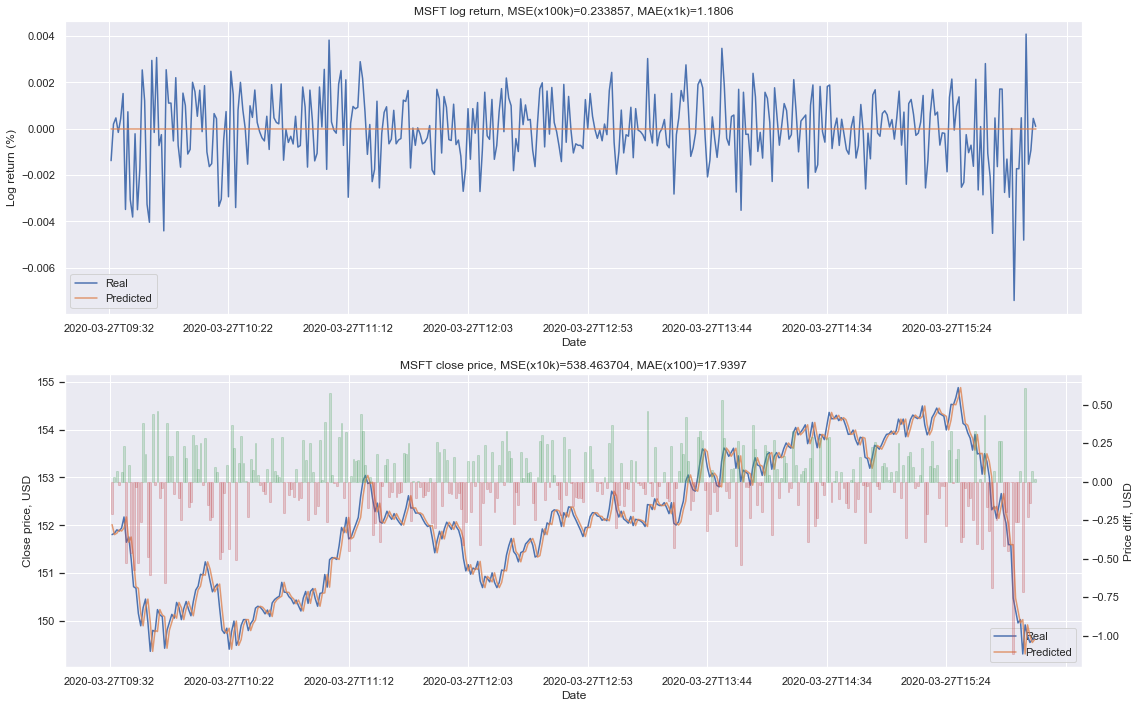

In [15]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 10),
                                  datetime_unit='m', plot_data_slice=slice(1, None))

## Классификация: подбрасывание монеты

Метрики классификации в данном случае, очевидно, практического смысла не имеют: хотя в среднем ROC AUC будет равен 0.5, но в какой-то отдельной реализации он может случайно получиться относительно большой. Тем не менее для примера посчитаем метрики и здесь.

In [16]:
pred_direction_proba = np.random.uniform(size=len(instr_test))
predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

true_direction = ClassificationGenerator.get_target_direction(instr_test.c[-len(pred_direction_proba):].data)

In [17]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       234
           1       0.50      0.53      0.51       214

    accuracy                           0.52       448
   macro avg       0.52      0.52      0.52       448
weighted avg       0.52      0.52      0.52       448



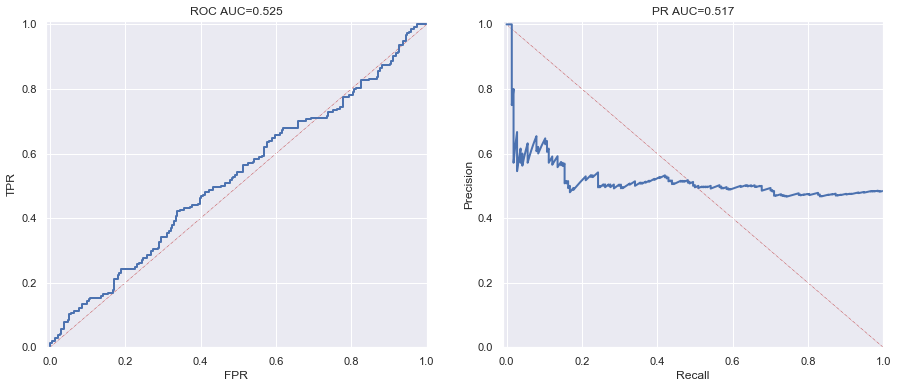

In [18]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)

Также посмотрим прогноз, который может сделать аддитивная модель библиотеки [FB Prophet](https://facebook.github.io/prophet) "из коробки".

На вход принимает датафрейм заданного формата.

In [19]:
prophet_train = pd.DataFrame(instr_train.c.asSeries()).reset_index()

prophet_train.columns = ['ds', 'y']

prophet_train.tail()

,ds,y
1519,2020-03-26 15:56:00,-0.004297
1520,2020-03-26 15:57:00,-0.000772
1521,2020-03-26 15:58:00,-0.000644
1522,2020-03-26 15:59:00,-0.000966
1523,2020-03-26 16:00:00,0.004757


#### Обучение:

In [20]:
prophet = Prophet()

prophet.fit(prophet_train);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Для сохранения результата прогноза также нужен датафрейм.

In [21]:
prophet_test = pd.DataFrame(instr_test.timestamps[WINDOW_SIZE:])

prophet_test.columns = ['ds']

prophet_test.head()

,ds
0,2020-03-27 09:31:00
1,2020-03-27 09:32:00
2,2020-03-27 09:33:00
3,2020-03-27 09:34:00
4,2020-03-27 09:35:00


#### Прогноз:

In [22]:
prophet_test = prophet.predict(prophet_test)

In [23]:
prophet_test.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
383,2020-03-27 15:56:00,0.00241,-0.003528,0.003212,0.002354,0.002461,-0.002471,-0.002471,-0.002471,-0.002471,-0.002471,-0.002471,0.0,0.0,0.0,-0.000061
384,2020-03-27 15:57:00,0.00241,-0.003489,0.003580,0.002354,0.002461,-0.002493,-0.002493,-0.002493,-0.002493,-0.002493,-0.002493,0.0,0.0,0.0,-0.000083
385,2020-03-27 15:58:00,0.00241,-0.003554,0.003238,0.002354,0.002461,-0.002514,-0.002514,-0.002514,-0.002514,-0.002514,-0.002514,0.0,0.0,0.0,-0.000104
386,2020-03-27 15:59:00,0.00241,-0.003669,0.003348,0.002354,0.002461,-0.002537,-0.002537,-0.002537,-0.002537,-0.002537,-0.002537,0.0,0.0,0.0,-0.000127
387,2020-03-27 16:00:00,0.00241,-0.003389,0.002937,0.002354,0.002461,-0.002561,-0.002561,-0.002561,-0.002561,-0.002561,-0.002561,0.0,0.0,0.0,-0.000151


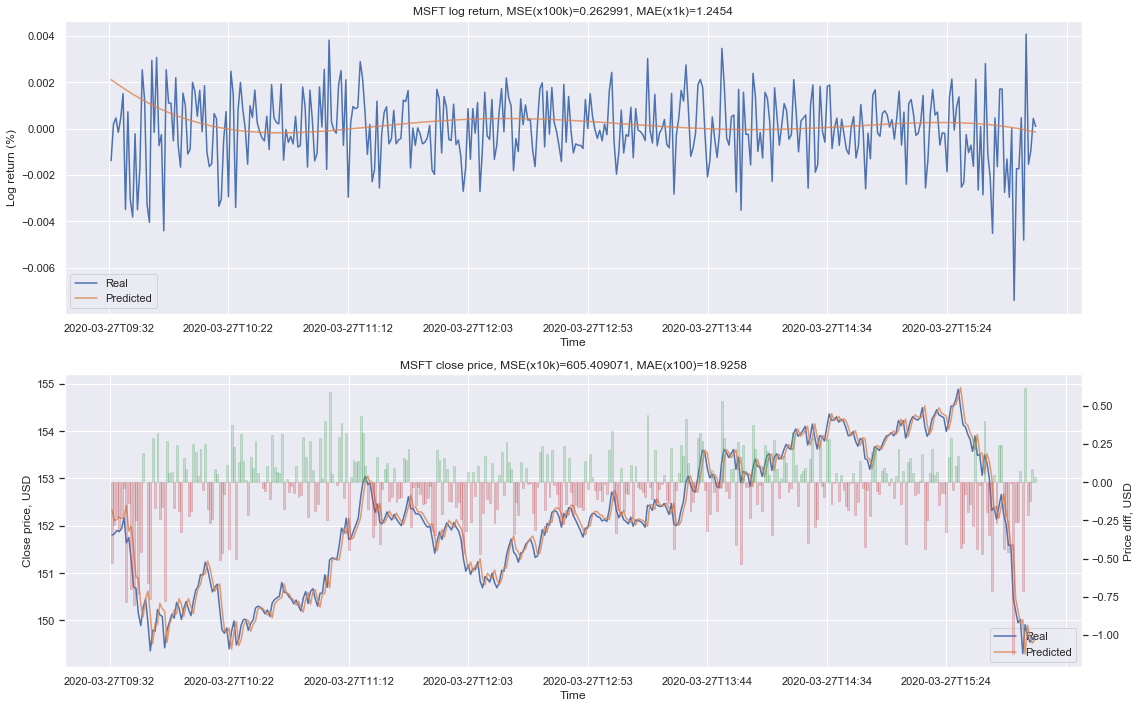

In [24]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, prophet_test['yhat'].values,
                                  datetime_unit='m', xlabel='Time', plot_data_slice=slice(1, None))

Прогноз с доверительными интервалами:

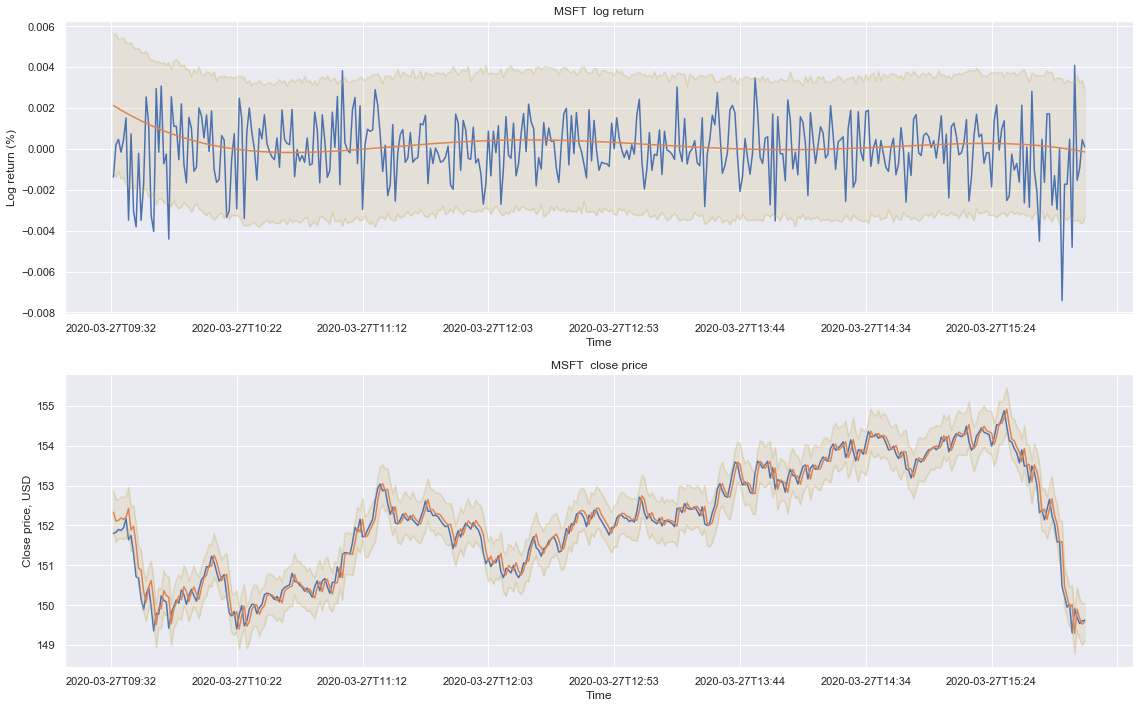

In [25]:
plotHelpers.plot_fbprohet_spread(orig_target, instr_test, prophet_test,
                                 datetime_unit='m', plot_data_slice=slice(1, None))

### Вывод

**Prophet** прогнозирует что-то близкое к модели случайного блуждания.